In [2]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import altair
import matplotlib.pyplot as plt

In [ ]:
#clean dataset

In [33]:
def df_clean(df):
    df.loc[:,'Mod'] = ''
    df.loc[:,'morethanonemod'] = 0
    for index, row in df.iterrows():
        fasta_temp = row['Proteins'].split('/')[0]
        df.loc[index, 'ACCID'] = fasta_temp.split('|')[1]
        df.loc[index, 'PROTEIN'] = fasta_temp.split('|')[2]

        for mod in row['Modification'].split(';'):
            if mod == '':
                break
            if mod.split(',')[1] in ['DiZSeK[S]','dioxDiZSeK[S]','oxDiZSeK[S]']:
                if df.loc[index,'Mod'] != '':
                    df.loc[index,'morethanonemod'] = 1
                    break
                df.loc[index,'Mod'] = mod.split(',')[1]
                df.loc[index,'P1'] = int(mod.split(',')[0])
                df.loc[index,'P2'] = int(row['Positions'].split(',')[0])
                df.loc[index, 'P'] = int(df.loc[index,'P1'] + df.loc[index,'P2'])
    return df


In [34]:
df_t = pd.read_excel('se_pfind.xlsx',sheet_name='trypsin')
df_c = pd.read_excel('se_pfind.xlsx',sheet_name='chymotrypsin')
df_g = pd.read_excel('se_pfind.xlsx',sheet_name='trypsin_gluc')

In [35]:
df_t = df_clean(df_t)
df_c = df_clean(df_c)
df_g = df_clean(df_g)

In [38]:
writer = pd.ExcelWriter('se_pfind_clean.xlsx', engine = 'xlsxwriter')
df_t.to_excel(writer, sheet_name= 'trypsin',index=False)
df_c.to_excel(writer, sheet_name= 'chymotrypsin',index=False)
df_g.to_excel(writer, sheet_name= 'trypsin_gluc',index=False)
writer.close()

In [ ]:
#extract sequence and codon

In [69]:
def df_annotation(df, mapping_df):
    df = pd.merge(df,mapping_df,left_on='ACCID', right_on='From')

    df = df.loc[(df.seq.isna() == False),:]

    for index,row in df.iterrows():
        nc_position = int(row.P) * 3
        df.loc[index, 'codon'] = row.seq[nc_position - 3 : nc_position]
        
        if (nc_position - 3 - 30) < 0:
            left_num = 0 - (nc_position - 3 - 30)
            left_str = '_' * left_num
            start_pos = 0
        else:
            start_pos = nc_position - 3 - 30
            left_str = ''

        if (nc_position + 30) > row.seq_len:
            right_num = (nc_position + 30) - int(row.seq_len)
            right_str = '_' * right_num
            end_pos = int(row.seq_len)
        else:
            end_pos = nc_position + 30
            right_str = ''
        
        nc_seq = left_str + row.seq[start_pos : end_pos] + right_str
        df.loc[index, 'subseq'] = nc_seq
    
    return df

In [70]:
df_t = pd.read_excel('se_pfind_clean.xlsx',sheet_name='trypsin')
df_c = pd.read_excel('se_pfind_clean.xlsx',sheet_name='chymotrypsin')
df_g = pd.read_excel('se_pfind_clean.xlsx',sheet_name='trypsin_gluc')

In [45]:
mapping = pd.read_table('se_pfind_accid_ccds_convert.tsv')
for seq_record in SeqIO.parse('CCDS_nucleotide.current.fna','fasta'):
    cds_id = seq_record.id.split('|')[0]
    if (mapping.To.eq(cds_id)).any():
        mapping.loc[mapping.To == cds_id, 'seq'] = str(seq_record.seq)
        mapping.loc[mapping.To == cds_id, 'seq_len'] = len(seq_record)
        
mapping = mapping.sort_values('seq_len',ascending=False).drop_duplicates('From').sort_index()

In [71]:
df_t = df_annotation(df_t,mapping)
df_c = df_annotation(df_c,mapping)
df_g = df_annotation(df_g,mapping)

In [72]:
writer = pd.ExcelWriter('se_pfind_annotation.xlsx', engine = 'xlsxwriter')
df_t.to_excel(writer, sheet_name= 'trypsin',index=False)
df_c.to_excel(writer, sheet_name= 'chymotrypsin',index=False)
df_g.to_excel(writer, sheet_name= 'trypsin_gluc',index=False)
writer.close()

In [73]:
#merge the results

In [74]:
df_t = pd.read_excel('se_pfind_annotation.xlsx',sheet_name='trypsin')
df_c = pd.read_excel('se_pfind_annotation.xlsx',sheet_name='chymotrypsin')
df_g = pd.read_excel('se_pfind_annotation.xlsx',sheet_name='trypsin_gluc')

In [75]:
df_t.loc[:,'Protease'] = 'Trypsin'
df_c.loc[:,'Protease'] = 'Chymotrypsin'
df_g.loc[:,'Protease'] = 'Trypsin_GluC'

In [80]:
df_merge = pd.concat([df_t,df_c,df_g])
df_merge = df_merge.loc[df_merge.codon == 'TCG',:]

In [83]:
df_merge.to_excel('se_pfind_merge.xlsx',index=False)

In [84]:
#generate background subseq list

In [2]:
bg_protein = pd.read_table('bg_protein_convert_ccds.tsv')

In [9]:
for seq_record in SeqIO.parse('CCDS_nucleotide.current.fna','fasta'):
    cds_id = seq_record.id.split('|')[0]
    if (bg_protein.To.eq(cds_id)).any():
        bg_protein.loc[bg_protein.To == cds_id, 'seq'] = str(seq_record.seq)
        bg_protein.loc[bg_protein.To == cds_id, 'seq_len'] = len(seq_record)
bg_protein = bg_protein.sort_values('seq_len',ascending=False).drop_duplicates('From').sort_index()

In [10]:
bg_protein.to_excel('bg_protein_seq.xlsx',index=False)

In [13]:
bg_protein = pd.read_excel('bg_protein.xlsx',sheet_name='Total_sequence')

In [14]:
for index,row in bg_protein.iterrows():
    i = 0
    while i < int(row.seq_len):
        if row.seq[i:i+3] == 'TCG':
            nc_position = i + 3
            
            if (nc_position - 3 - 30) < 0:
                left_num = 0 - (nc_position - 3 - 30)
                left_str = '_' * left_num
                start_pos = 0
            else:
                start_pos = nc_position - 3 - 30
                left_str = ''

            if (nc_position + 30) > row.seq_len:
                right_num = (nc_position + 30) - int(row.seq_len)
                right_str = '_' * right_num
                end_pos = int(row.seq_len)
            else:
                end_pos = nc_position + 30
                right_str = ''
            
            nc_seq = left_str + row.seq[start_pos : end_pos] + right_str
            
            with open('bg_subseq_list.txt', 'a+') as f:
                f.write(nc_seq)
                f.write('\n')
        
        i = i + 3

In [ ]:
#se bg proteins

In [592]:
bg_protein = pd.read_table('se_bg_protein_convert_ccds.tsv')

In [593]:
for seq_record in SeqIO.parse('CCDS_nucleotide.current.fna','fasta'):
    cds_id = seq_record.id.split('|')[0]
    if (bg_protein.To.eq(cds_id)).any():
        bg_protein.loc[bg_protein.To == cds_id, 'seq'] = str(seq_record.seq)
        bg_protein.loc[bg_protein.To == cds_id, 'seq_len'] = len(seq_record)
bg_protein = bg_protein.sort_values('seq_len',ascending=False).drop_duplicates('From').sort_index()

In [594]:
bg_protein.to_excel('se_bg_protein_seq.xlsx',index=False)

In [595]:
bg_protein = pd.read_excel('se_bg_protein_seq.xlsx')

In [596]:
for index,row in bg_protein.iterrows():
    i = 0
    while i < int(row.seq_len):
        if row.seq[i:i+3] == 'TCG':
            nc_position = i + 3
            
            if (nc_position - 3 - 30) < 0:
                left_num = 0 - (nc_position - 3 - 30)
                left_str = '_' * left_num
                start_pos = 0
            else:
                start_pos = nc_position - 3 - 30
                left_str = ''

            if (nc_position + 30) > row.seq_len:
                right_num = (nc_position + 30) - int(row.seq_len)
                right_str = '_' * right_num
                end_pos = int(row.seq_len)
            else:
                end_pos = nc_position + 30
                right_str = ''
            
            nc_seq = left_str + row.seq[start_pos : end_pos] + right_str
            
            with open('se_bg_subseq_list.txt', 'a+') as f:
                f.write(nc_seq)
                f.write('\n')
        
        i = i + 3

In [ ]:
#score calculation test and adjust

In [621]:
f = open('weights/weights_20230512_plogo.txt','r')
lines = f.readlines()

weights = np.zeros((60,4))

for line in lines:
    nc = line.split('[')[1].split('_')[0]
    if nc == 'A':
        nc = 0
    elif nc == 'T':
        nc = 1
    elif nc == 'C':
        nc = 2
    elif nc == 'G':
        nc = 3

    i = line.split('_')[1].split('=')[0]
    i = int(i)
    if i == 0:
        continue
    if i == 1:
        continue
    if i == -1:
        continue

    if i < 0:
        i = i + 31
    elif i > 0:
        i = i + 28
    
    w = line.split('=')[1].split(']')[0]
    w = float(w)

    weights[i,nc] = w

f.close()

In [622]:
np.savetxt("weights/weights_20230512.txt", weights)

In [623]:
weights = np.loadtxt("weights/weights_20230512.txt")

In [2]:
seq_eff = pd.read_excel('weights/test_data.xlsx',sheet_name='seq_eff')

In [5]:
#two side test

In [3]:
def matrix_construct_adjust(seq, contain_mid=True, oneside_num=30):
    if contain_mid:
        if len(seq) != oneside_num * 2 + 3:
            raise Exception('seq len is wrong!')
    elif contain_mid == False:
        if len(seq) != oneside_num * 2:
            raise Exception('seq len is wrong!')

    if contain_mid:
        seq = seq[0:oneside_num] + seq[oneside_num + 3: oneside_num * 2 + 3]
    
    seq_matrix = np.zeros((oneside_num * 2,4))
    i = 0

    for nc in seq:
        if nc == 'A':
            nc = 0
        elif nc == 'T':
            nc = 1
        elif nc == 'C':
            nc = 2
        elif nc == 'G':
            nc = 3
        
        seq_matrix[i,nc] = 1
        i = i + 1
    
    return(seq_matrix)

def score_cal_adjust(seq_matrix, weights_matrix,oneside_num=30):
    weights_matrix = weights_matrix[30 - oneside_num : oneside_num + 30]
    result_matrix = weights_matrix * seq_matrix
    result = (np.sum(result_matrix) - np.sum(np.min(weights_matrix,axis=1))) / (np.sum(np.max(weights_matrix,axis=1)) - np.sum(np.min(weights_matrix,axis=1)))
    #result = np.sum(result_matrix) 
    return(result)

def matrix_construct_adjust_l(seq, contain_mid=True, oneside_num=30):
    seq_matrix = np.zeros((oneside_num,4))
    i = 0

    for nc in seq:
        if nc == 'A':
            nc = 0
        elif nc == 'T':
            nc = 1
        elif nc == 'C':
            nc = 2
        elif nc == 'G':
            nc = 3
        
        seq_matrix[i,nc] = 1
        i = i + 1
    
    return(seq_matrix)

def score_cal_adjust_l(seq_matrix, weights_matrix,oneside_num=30):
    weights_matrix = weights_matrix[30 - oneside_num : 30]
    result_matrix = weights_matrix * seq_matrix
    result = (np.sum(result_matrix) - np.sum(np.min(weights_matrix,axis=1))) / (np.sum(np.max(weights_matrix,axis=1)) - np.sum(np.min(weights_matrix,axis=1)))
    #result = np.sum(result_matrix) 
    return(result)

In [4]:
weights = np.loadtxt('weights/weights_kpLogo_rank.txt')

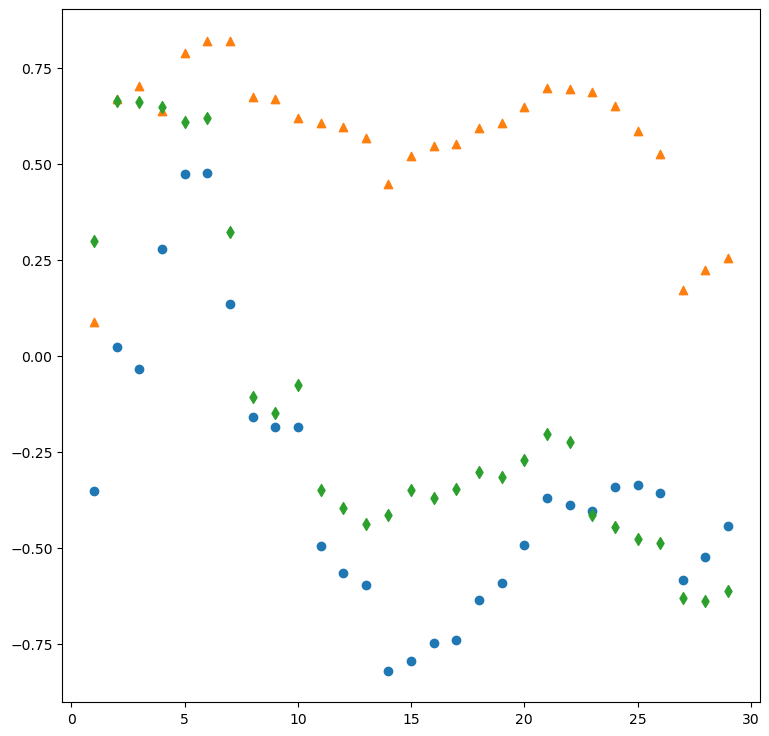

In [19]:
pearson_list_1 = []
pearson_list_2 = []
pearson_list_7 = []
pearson_list_10 = []
oneside_list = range(1,30)
for n in oneside_list:
    score_list = []
    for index,row in seq_eff.iterrows():
        seq_eff.loc[index,'score_adjust'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n : 33 + n],oneside_num=n),weights,oneside_num=n)
    pearson_list_1.append(np.corrcoef(seq_eff[seq_eff.Condition == 'YW-1'].Ratio, seq_eff[seq_eff.Condition == 'YW-1'].score_adjust)[0,1])
    pearson_list_2.append(np.corrcoef(seq_eff[seq_eff.Condition == 'YW-2'].Ratio, seq_eff[seq_eff.Condition == 'YW-2'].score_adjust)[0,1])
    pearson_list_7.append(np.corrcoef(seq_eff[seq_eff.Condition == 'YW-7'].Ratio, seq_eff[seq_eff.Condition == 'YW-7'].score_adjust)[0,1])
    pearson_list_10.append(np.corrcoef(seq_eff[seq_eff.Condition == 'LLH-10'].Ratio, seq_eff[seq_eff.Condition == 'LLH-10'].score_adjust)[0,1])

pearson_list_1 = np.array(pearson_list_1)
pearson_list_2 = np.array(pearson_list_2)
pearson_list_7 = np.array(pearson_list_7)
pearson_list_10 = np.array(pearson_list_10)
oneside_list = np.array(oneside_list)

plt.figure(figsize=(9,9))
plt.scatter(x = oneside_list, y = pearson_list_1, marker='o')
plt.scatter(x = oneside_list, y = pearson_list_2, marker='^')
plt.scatter(x = oneside_list, y = pearson_list_7, marker='d')
#plt.scatter(x = oneside_list, y = pearson_list_10, marker='s')
plt.show()

In [628]:
#weights[30:60,:] = 0.2 * weights[30:60,:]

In [681]:
f = open('weights/weights_top500.txt','r')
lines = f.readlines()

weights = np.zeros((60,4))

for line in lines:
    nc = line.split('[')[1].split('_')[0]
    if nc == 'A':
        nc = 0
    elif nc == 'T':
        nc = 1
    elif nc == 'C':
        nc = 2
    elif nc == 'G':
        nc = 3

    i = line.split('_')[1].split('=')[0]
    i = int(i)
    if i == 0:
        continue
    if i == 1:
        continue
    if i == -1:
        continue

    if i < 0:
        i = i + 31
    elif i > 0:
        i = i + 28
    
    w = line.split('=')[1].split(']')[0]
    w = float(w)

    weights[i,nc] = w

f.close()

In [6]:
n = 3
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n : 33 + n],oneside_num=n),weights,oneside_num=n)

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [7]:
n = 6
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n : 33 + n],oneside_num=n),weights,oneside_num=n)

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [8]:
n = 9
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n : 33 + n],oneside_num=n),weights,oneside_num=n)

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [9]:
n = 12
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n : 33 + n],oneside_num=n),weights,oneside_num=n)

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [10]:
n = 3
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust_l(matrix_construct_adjust_l(row.CutSeq63[30 - n : 30],oneside_num=n),weights,oneside_num=n)

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [11]:
n = 6
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust_l(matrix_construct_adjust_l(row.CutSeq63[30 - n : 30],oneside_num=n),weights,oneside_num=n)

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [12]:
n = 9
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust_l(matrix_construct_adjust_l(row.CutSeq63[30 - n : 30],oneside_num=n),weights,oneside_num=n)

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [13]:
n = 12
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust_l(matrix_construct_adjust_l(row.CutSeq63[30 - n : 30],oneside_num=n),weights,oneside_num=n)

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [21]:
n1 = 3
n2 = 6
#n3 = 9
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score1'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n1 : 33 + n1],oneside_num=n1),weights,oneside_num=n1)
    seq_eff.loc[index,'score2'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n2 : 33 + n2],oneside_num=n2),weights,oneside_num=n2)
    #seq_eff.loc[index,'score3'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n3 : 33 + n3],oneside_num=n3),weights,oneside_num=n3)

seq_eff.loc[:,'score'] = seq_eff.loc[:,'score1'] + seq_eff.loc[:,'score2'] #+ seq_eff.loc[:,'score3']

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [17]:
n1 = 6
n2 = 6
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score1'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n1 : 33 + n1],oneside_num=n1),weights,oneside_num=n1)
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score2'] = score_cal_adjust_l(matrix_construct_adjust_l(row.CutSeq63[30 - n2 : 30],oneside_num=n2),weights,oneside_num=n2)
seq_eff.loc[:,'score'] =  (2 * seq_eff.loc[:,'score2']) - (seq_eff.loc[:,'score1'])

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [631]:
#one side test

c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


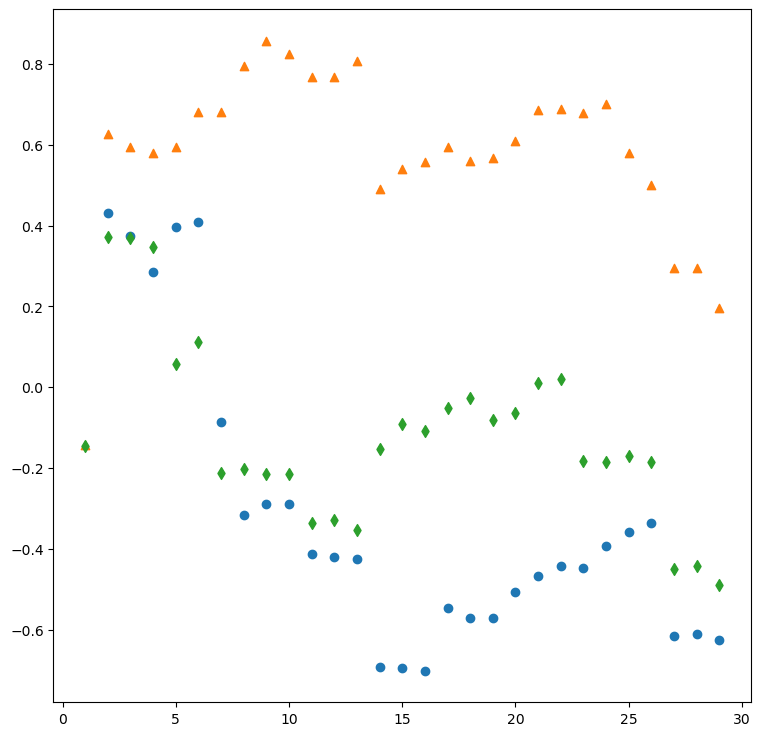

In [20]:
pearson_list_1_l = []
pearson_list_2_l = []
pearson_list_7_l = []
pearson_list_10_l = []
oneside_list = range(1,30)
for n in oneside_list:
    score_list = []
    for index,row in seq_eff.iterrows():
        seq_eff.loc[index,'score_adjust_l'] = score_cal_adjust_l(matrix_construct_adjust_l(row.CutSeq63[30 - n : 30],oneside_num=n),weights,oneside_num=n)
    pearson_list_1_l.append(np.corrcoef(seq_eff[seq_eff.Condition == 'YW-1'].Ratio, seq_eff[seq_eff.Condition == 'YW-1'].score_adjust_l)[0,1])
    pearson_list_2_l.append(np.corrcoef(seq_eff[seq_eff.Condition == 'YW-2'].Ratio, seq_eff[seq_eff.Condition == 'YW-2'].score_adjust_l)[0,1])
    pearson_list_7_l.append(np.corrcoef(seq_eff[seq_eff.Condition == 'YW-7'].Ratio, seq_eff[seq_eff.Condition == 'YW-7'].score_adjust_l)[0,1])
    pearson_list_10_l.append(np.corrcoef(seq_eff[seq_eff.Condition == 'LLH-10'].Ratio, seq_eff[seq_eff.Condition == 'LLH-10'].score_adjust_l)[0,1])

pearson_list_1_l = np.array(pearson_list_1_l)
pearson_list_2_l = np.array(pearson_list_2_l)
pearson_list_7_l = np.array(pearson_list_7_l)
pearson_list_10_l = np.array(pearson_list_10_l)
oneside_list = np.array(oneside_list)

plt.figure(figsize=(9,9))
plt.scatter(x = oneside_list, y = pearson_list_1_l, marker='o')
plt.scatter(x = oneside_list, y = pearson_list_2_l, marker='^')
plt.scatter(x = oneside_list, y = pearson_list_7_l, marker='d')
#plt.scatter(x = oneside_list, y = pearson_list_10_l, marker='s')
plt.show()

In [28]:
n = 12
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust_l(matrix_construct_adjust_l(row.CutSeq63[30 - n : 30],oneside_num=n),weights,oneside_num=n)

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [634]:
n1 = 3
n2 = 9
#n3 = 9
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score1'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n1 : 33 + n1],oneside_num=n1),weights,oneside_num=n1)
    seq_eff.loc[index,'score2'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n2 : 33 + n2],oneside_num=n2),weights,oneside_num=n2)
    #seq_eff.loc[index,'score3'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n3 : 33 + n3],oneside_num=n3),weights,oneside_num=n3)

seq_eff.loc[:,'score'] = seq_eff.loc[:,'score1'] + seq_eff.loc[:,'score2'] #+ seq_eff.loc[:,'score3']

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [635]:
n1 = 3
n2 = 9
#n3 = 9
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score1'] = score_cal_adjust_l(matrix_construct_adjust_l(row.CutSeq63[30 - n1 : 30],oneside_num=n1),weights,oneside_num=n1)
    seq_eff.loc[index,'score2'] = score_cal_adjust_l(matrix_construct_adjust_l(row.CutSeq63[30 - n2 : 30],oneside_num=n2),weights,oneside_num=n2)
    #seq_eff.loc[index,'score3'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n3 : 33 + n3],oneside_num=n3),weights,oneside_num=n3)

seq_eff.loc[:,'score'] = seq_eff.loc[:,'score1'] + seq_eff.loc[:,'score2'] #+ seq_eff.loc[:,'score3']

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [636]:
#svm

In [637]:
seq_eff = pd.read_excel('weights/test_data.xlsx',sheet_name='seq_eff')

In [638]:
def matrix_construct_adjust(seq, contain_mid=True, oneside_num=30):
    if contain_mid:
        if len(seq) != oneside_num * 2 + 3:
            raise Exception('seq len is wrong!')
    elif contain_mid == False:
        if len(seq) != oneside_num * 2:
            raise Exception('seq len is wrong!')

    if contain_mid:
        seq = seq[0:oneside_num] + seq[oneside_num + 3: oneside_num * 2 + 3]
    
    seq_matrix = np.zeros((oneside_num * 2,4))
    i = 0

    for nc in seq:
        if nc == 'A':
            nc = 0
        elif nc == 'T':
            nc = 1
        elif nc == 'C':
            nc = 2
        elif nc == 'G':
            nc = 3
        
        seq_matrix[i,nc] = 1
        i = i + 1
    
    return(seq_matrix)

def score_cal_sites_adjust(seq_matrix, weights_matrix,oneside_num=30):
    weights_matrix = weights_matrix[30 - oneside_num : oneside_num + 30]
    result_matrix = weights_matrix * seq_matrix
    result = np.sum(result_matrix,axis=1)
    return(result)

In [639]:
score_cal_sites_adjust(matrix_construct_adjust('ACCCTGCAGCTGGAAAGCGTTGATCCGAAATCGTATCCGAAAAAGAAAATGGAAAAACGTTTT'),weights)

array([ -4.79708 ,   2.26784 ,   1.10908 ,   0.466964,  -0.324646,
         2.85047 ,   0.297921,  -3.1604  ,   1.35498 ,   1.53857 ,
         0.55306 ,   3.68915 ,   6.51527 ,  -8.27944 ,  -1.09286 ,
        -0.802929,   0.451739,   1.03386 ,   7.84076 ,   1.27895 ,
        -2.69768 ,   4.63865 ,  -7.84501 ,  -2.64262 ,   1.51159 ,
         3.11712 ,   2.08511 ,  -7.44127 ,  -9.67676 ,  -1.64657 ,
        -1.72635 ,  -9.63207 ,  -0.792194,   0.787553,   0.475325,
         1.75366 ,  -0.748451,  -6.96467 ,  -1.53838 ,  -2.40568 ,
        -7.03708 ,   3.86798 ,  -1.93675 , -11.5976  ,  -4.71812 ,
        -2.05465 ,  -1.10432 ,   0.831928,   0.253386,  -3.41288 ,
        -4.51292 ,  -0.956485,  -5.38151 ,  -1.80682 ,  -0.176708,
         1.62369 ,  -0.640976,   0.712394,  -0.685999,  -3.54349 ])

In [640]:
result_list = []
for index,row in seq_eff.iterrows():
    result = score_cal_sites_adjust(matrix_construct_adjust(row.CutSeq63[21:42],oneside_num=9),weights,oneside_num=9)
    result_list.append(result)

In [641]:
r_df = pd.DataFrame(result_list)
y = seq_eff.loc[:,'Ratio']

In [642]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVC

In [643]:
X_train, X_test, y_train, y_test = train_test_split(r_df,y,random_state=42)

In [644]:
X_train, X_test, y_train, y_test = train_test_split(r_df,y,random_state=42)
lr = Ridge(alpha=50).fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

0.48158344635559247
0.2870178053470286


In [645]:
y_pred = lr.predict(X_test)
print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

0.48158344635559247
0.2870178053470286


In [646]:
np.corrcoef(y_pred,y_test)

array([[1.        , 0.56478736],
       [0.56478736, 1.        ]])

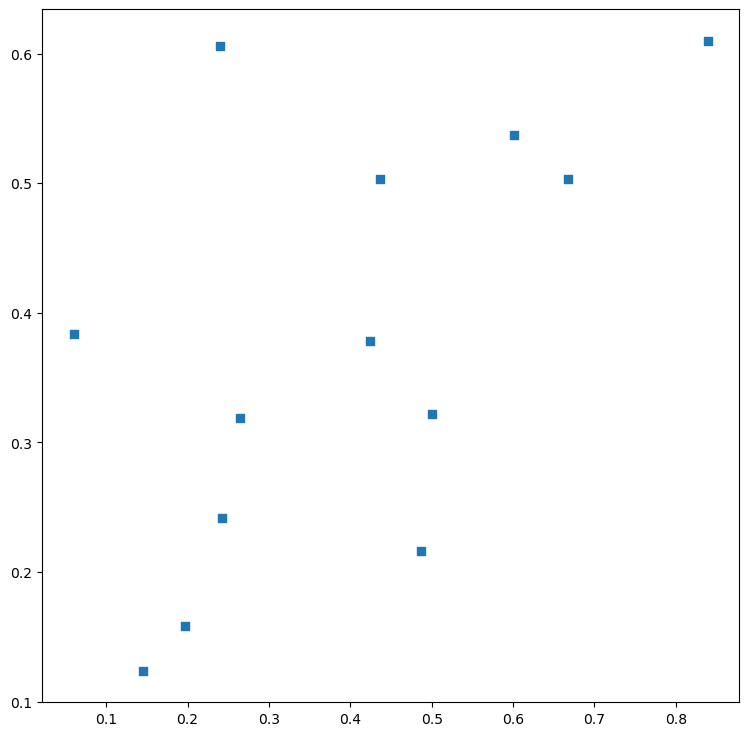

In [647]:
plt.figure(figsize=(9,9))
plt.scatter(x = y_test, y = y_pred, marker='s')
plt.show()

In [648]:
ww = np.array(lr.coef_)

In [649]:
#weights_w = weights * ww[:,None]

In [650]:
#n = 30
#for index,row in seq_eff.iterrows():
    #seq_eff.loc[index,'score'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n : 33 + n],oneside_num=n),weights_w,oneside_num=n)

seq_eff.loc[:,'score'] = lr.predict(r_df)
altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

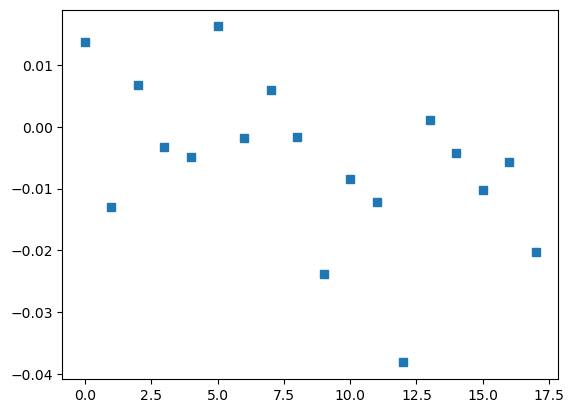

In [651]:
plt.plot(ww,'s')

In [652]:
np.savetxt('ridge.txt',ww)

In [ ]:
#combine

In [22]:
weights1 = np.loadtxt('weights/weights_kpLogo_rank.txt')
weights2 = np.loadtxt('weights/weights_kpLogo.txt')

In [28]:
n1 = 6
n2 = 6
#n3 = 9
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score1'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n1 : 33 + n1],oneside_num=n1),weights1,oneside_num=n1)
    seq_eff.loc[index,'score2'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n2 : 33 + n2],oneside_num=n2),weights2,oneside_num=n2)
    #seq_eff.loc[index,'score3'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n3 : 33 + n3],oneside_num=n3),weights,oneside_num=n3)

seq_eff.loc[:,'score'] = seq_eff.loc[:,'score1'] + seq_eff.loc[:,'score2'] #+ seq_eff.loc[:,'score3']

altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [32]:
weights_c = (weights1 + weights2) / 2

In [34]:
n = 6
for index,row in seq_eff.iterrows():
    seq_eff.loc[index,'score'] = score_cal_adjust(matrix_construct_adjust(row.CutSeq63[30 - n1 : 33 + n],oneside_num=n),weights_c,oneside_num=n)


altair.Chart(seq_eff).mark_point().encode(x='Ratio',y='score',color='Condition').properties(width=100,height=100).facet(facet='Condition',columns=4)

alt.FacetChart(...)

In [31]:
np.savetxt('weights/weights_kpLogo_combine.txt',weights_c)

In [1]:
#make logo

In [3]:
import logomaker

In [5]:
logomaker.get_example_matrix('ss_probability_matrix',print_description=False)

,A,C,G,U
pos,,,,
0,0.324656,0.358980,0.189313,0.127051
1,0.628560,0.110845,0.120658,0.139936
2,0.105337,0.027597,0.794143,0.072923
3,0.000000,0.000000,1.000000,0.000000
4,0.000000,0.028156,0.000000,0.971844
5,0.572633,0.038576,0.347800,0.040991
6,0.666476,0.085075,0.128766,0.119683
7,0.092191,0.065904,0.757889,0.084016
8,0.177637,0.156259,0.193662,0.472442


In [16]:
weights_l = pd.read_table('weights/weights_kpLogo_combine_acgt.txt')

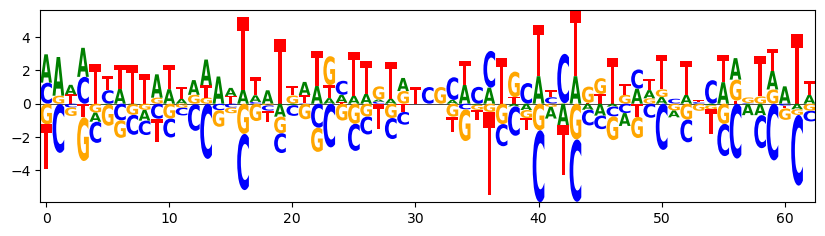

In [20]:
p = logomaker.Logo(weights_l,flip_below=False)
plt.savefig('logo_combined.pdf')